In [4]:
import requests
import time
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import warnings
import yaml
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from pycaret.datasets import get_data
from pycaret.classification import *

### Get Candlestick Data

In [5]:
now = datetime.now()

In [6]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    k_number = cfg['knn']['k_number']
    metric = cfg['knn']['metric']
    algorithm = cfg['knn']['algorithm']
    feature_1 = cfg['knn']['feature_1']
    feature_2 = cfg['knn']['feature_2']
    feature_3 = cfg['knn']['feature_3']
    feature_7 = cfg['knn']['feature_7']
    feature_8 = cfg['knn']['feature_8']
    feature_9 = cfg['knn']['feature_9']
    feature_10 = cfg['knn']['feature_10']
    feature_11 = cfg['knn']['feature_11']
    feature_12 = cfg['knn']['feature_12']
    feature_13 = cfg['knn']['feature_13']
    feature_14 = cfg['knn']['feature_14']
    volume = cfg['feature']['volume']
    volume_size = cfg['sample']['volume_size']
    sample_count = cfg['sample']['count']
    candles = cfg['recommendation']['candle_count']
    pair = cfg['currency']['pair']
    instrument = cfg['currency']['instrument']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']
    model = cfg['model']['name']

In [7]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)
print('Future Candle Count:', candles)
print('Pair:', pair)


K Number: 5
Metric: euclidean
Algorithm: brute
Candle Volume Size: 4000
Random Sample Count: 10000
Future Candle Count: 7
Pair: EURUSD


In [8]:
with open ('config.yml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    oanda_api_key = cfg['creds']['oanda_api']
    account_number = cfg['creds']['account_number'] 

In [9]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [10]:
print('Instrument:', instrument)

Instrument: EUR_USD


In [8]:
Load_10K_Records=True
Load_20K_Records=True

currency_pairs = [instrument]


timeframe = "H4"
#D #H1 #H4 M30
# https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
price_char = "M"
#M(midpoint candles) #B(bid candles) #A(ask candles) #BA
price_com = "mid"
#mid #bid #ask

# def of OANDA request variable
provider_api_url = 'https://api-fxpractice.oanda.com/v3/accounts/{}/orders'.format(account_number)
request_headers = {
    "Authorization": oanda_api_key,
    "Accept-Datetime-Format": "RFC3339",
    "Connection": "Keep-Alive",
    "Content-Type": "application/json;charset=UTF-8"
}


In [9]:
provider_authorization = 'Bearer {0}'.format(oanda_api_key)

headers = {
    'Content-Type': 'application/json',
    'Authorization': provider_authorization,
}

In [10]:
params_count = (
    ('price', price_char),
    ('count', '5000'),
    ('granularity', timeframe),
)


In [11]:
for pair in currency_pairs:
    first_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair), 
                            headers=headers,
                            params=params_count).json()

In [12]:
if Load_10K_Records:
    
    #### Load 10K data
        
    datetime_object = parser.parse(first_response['candles'][0]['time'])
    date= datetime_object - relativedelta(years=3)  
    from_date = date.replace(tzinfo=timezone.utc).timestamp()
    params_date = (
        ('count', '5000'),
        ('price', price_char),
        ('from', from_date),
        ('granularity', timeframe),)

    second_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                   headers=headers,
                                   params=params_date).json()
    datetime_object_15K = parser.parse(second_response['candles'][0]['time'])
    first_response= first_response['candles']  
    second_response= second_response['candles']
    second_response.extend(first_response)
    
    if Load_20K_Records:

        #### Load 15K data

        date= datetime_object_15K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        third_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(third_response['candles'][0]['time'])
        third_response= third_response['candles']
        third_response.extend(second_response)

        #### Load 20K data

        date= datetime_object_20K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        fourth_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(fourth_response['candles'][0]['time'])
        fourth_response= fourth_response['candles']
        fourth_response.extend(third_response)

        response=fourth_response
    else:
       response=second_response 
else:
    response=first_response['candles']

In [13]:
filename = "{}_{}.csv".format(pair, timeframe)
output = []
all_candlesticks = response

for i in range (len(all_candlesticks)):
    result= (convert_date(response[i]['time']))
    output.append([(result[0]),(result[1]),(result[2]),(result[3]),(result[4]),(result[5]),
                    response[i]['time'],
                    response[i]['volume'], 
                    response[i][price_com]['o'],
                    response[i][price_com]['h'],
                    response[i][price_com]['l'],
                    response[i][price_com]['c']])
    
output = pd.DataFrame(output)
output.columns = ['Date','Time','f_time','julian_date','Weekday','Weekday_Name','UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close']
data = output.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [14]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [15]:
data.shape

(19342, 12)

In [16]:
data['SMA_5'] = data['Close'].rolling(window=5).mean().round(4)
data['SMA_10'] = data['Close'].rolling(window=10).mean().round(4)
data['SMA_20'] = data['Close'].rolling(window=20).mean().round(4)

In [17]:
data['F_SMA_5'] = data['Close'] - data['SMA_5']
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [18]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [19]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

In [20]:
data = data.dropna()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [21]:
data.shape

(19323, 30)

### Generating Training Data

In [22]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [23]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)

K Number: 5
Metric: euclidean
Algorithm: brute


In [11]:
def find_k_similar_candles(candle_id, dataset, k = k_number):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = metric, algorithm = algorithm) 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i!=0:
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
                            dataset.iloc[indices.flatten()[i]][feature_9],
                            dataset.iloc[indices.flatten()[i]][feature_10],
                            dataset.iloc[indices.flatten()[i]][feature_11],
                            dataset.iloc[indices.flatten()[i]][feature_12],
                            dataset.iloc[indices.flatten()[i]][feature_13],
                            dataset.iloc[indices.flatten()[i]][feature_14],
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
                      feature_9,
                      feature_10,
                      feature_11,
                      feature_12,
                      feature_13,
                      feature_14,
                     ]
   # display (output)
    
    return indices, distances

# <font color='red'>Test Configs</font>

In [25]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [26]:
data.columns

Index(['Date', 'Time', 'f_time', 'julian_date', 'Weekday', 'Weekday_Name',
       'UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10',
       'SMA_20', 'F_SMA_5', 'F_SMA_10', 'F_SMA_20', 'O-H', 'O-L', 'O-C', 'H-L',
       'H-C', 'L-C', 'Direction', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5'],
      dtype='object')

## Selecting n random candles where their volume is more than x

In [27]:
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)

Candle Volume Size: 4000
Random Sample Count: 10000


In [28]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)

In [29]:
#Random_Candles = np.random.randint(low=1, high=len(data)-40, size=1000)
Random_Candles = list(random_samples.index.values)

# <font color='red'>CANDLE LOOP</font>

In [30]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [31]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
                              'Rec1_Score':[],
                              'Rec1_Prediction':[],
                              'Rec2_Score':[],
                              'Rec2_Prediction':[],
                              'Rec3_Score':[],
                              'Rec3_Prediction':[],
                              'Rec4_Score':[],
                              'Rec4_Prediction':[]
                             })

for candle_no in Random_Candles:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    #print(Current_Market_Fit)
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market='Bullish'
    else:
        Current_Market = 'Bearish'
    
    data = pd.read_csv(filename)
    data = data[[feature_9,
                 feature_10,
                 feature_11,
                 feature_12,
                 feature_13,
                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade= 'BUY'
        else:
            Predicted_Trade = 'SELL'
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
              'Rec1_Score': predicted_output[0][0],
              'Rec1_Prediction': predicted_output[0][1],
              'Rec2_Score': predicted_output[1][0],
              'Rec2_Prediction': predicted_output[1][1],
              'Rec3_Score': predicted_output[2][0],
              'Rec3_Prediction': predicted_output[2][1],
              'Rec4_Score': predicted_output[3][0],
              'Rec4_Prediction': predicted_output[3][1],
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 03-02-2022_05-52_AM
CPU times: user 5h 54min 57s, sys: 6h 54min 18s, total: 12h 49min 16s
Wall time: 2h 19min 7s


In [32]:
result_output.to_csv('01_Back_Test_Data.csv', header = True, index = False)
result_output.to_csv(today + "_" + "Back_Test_Data_" + pair + '.csv', header = True, index = False)
result_output = pd.read_csv(today + "_" + "Back_Test_Data_" + pair + '.csv')
result_output.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,16061.0,83.429012,Bearish,76.350292,BUY,7.589357,SELL,0.008686,SELL,81.222464,SELL
1,9351.0,25.720240,Bullish,8.170866,BUY,4.948899,SELL,8.225812,BUY,91.143435,SELL
2,18840.0,0.009115,Bearish,25.144194,SELL,88.790150,SELL,38.352318,SELL,13.709951,BUY
3,2467.0,48.130979,Bullish,39.009064,SELL,80.836492,SELL,73.367726,SELL,82.929540,BUY
4,2877.0,61.181974,Bearish,1.430894,BUY,25.141188,BUY,74.599068,BUY,1.287533,BUY


In [33]:
result_output.shape

(10000, 11)

#### Generating Log File

In [34]:
file = open(today + "_" + "data_generation_log_" + pair + '.txt', "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "K_Number: " + str(k_number) + "\n" + \
            "KNN_Metric: " + metric + "\n" + \
            "KNN_Algorithm: " + algorithm + "\n" + \
            "Feature: " + feature_9 + "\n" + \
            "Feature: " + feature_10 + "\n" + \
            "Feature: " + feature_11 + "\n" + \
            "Feature: " + feature_12 + "\n" + \
            "Feature: " + feature_13 + "\n" + \
            "Feature: " + feature_14 + "\n" + \
            "Volume Size: " + str(volume_size) + "\n" + \
            "Sample Count: " + str(sample_count) + "\n" + \
            "Candle Counts: " + str(candles) + "\n"
           )
file.close()

### Modeling

In [101]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [102]:
print('Pair:', pair)
print('Fraction:', frac)
print('Random State:', random_state)

Pair: EURUSD
Fraction: 0.7
Random State: 900


In [103]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [104]:
dataset = pd.read_csv('01_Back_Test_Data.csv')
dataset.shape

(10000, 11)

In [105]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [106]:
dataset.shape

(7253, 11)

In [107]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [108]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [109]:
dataset['Rec1_Score'] = dataset['Rec1_Score'].round(2)
dataset['Rec2_Score'] = dataset['Rec2_Score'].round(2)
dataset['Rec3_Score'] = dataset['Rec3_Score'].round(2)
dataset['Rec4_Score'] = dataset['Rec4_Score'].round(2)

In [110]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [111]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,0,76.35,-7.59,-0.01,-81.22
1,1,8.17,-4.95,8.23,-91.14
2,1,-39.01,-80.84,-73.37,82.93
3,0,1.43,25.14,74.60,1.29
4,1,-43.77,82.74,95.51,84.69


In [112]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('Fraction: ' + str(frac))
#print('Random State: ', str(random_state))

Data for Modeling: (5077, 5)
Unseen Data For Predictions: (2176, 5)
Fraction: 0.7


In [113]:
data_unseen.shape

(2176, 5)

In [114]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-61.76,-86.55,-75.93,16.74
1,0,81.68,-73.63,82.94,-1.29
2,1,3.88,86.33,-61.67,26.36
3,1,-20.82,50.50,-83.59,12.96
4,0,43.11,49.99,-17.58,66.50


In [115]:
exp_name = setup(data = data,
                 target = 'Current_Market',
#                 fold_shuffle=True,
                 session_id=123,
                 silent=True,
#                 n_jobs = 64,
#                 imputation_type='iterative'
                ) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5077, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [116]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5072,0.5056,0.5289,0.5169,0.5226,0.0134,0.0134,0.0180
et,Extra Trees Classifier,0.5063,0.5023,0.5052,0.5171,0.5108,0.0127,0.0127,0.0850
ridge,Ridge Classifier,0.5060,0.0000,0.7137,0.5108,0.5948,0.0035,0.0054,0.0060
lda,Linear Discriminant Analysis,0.5060,0.4977,0.7137,0.5108,0.5948,0.0035,0.0054,0.0050
lr,Logistic Regression,0.5058,0.4977,0.7132,0.5105,0.5945,0.0029,0.0048,0.0080
gbc,Gradient Boosting Classifier,0.5046,0.5066,0.6184,0.5124,0.5600,0.0046,0.0046,0.0650
rf,Random Forest Classifier,0.5030,0.4949,0.5118,0.5135,0.5123,0.0055,0.0055,0.1070
knn,K Neighbors Classifier,0.5010,0.4956,0.5169,0.5106,0.5136,0.0013,0.0014,0.0210
nb,Naive Bayes,0.5001,0.4887,0.7082,0.5067,0.5901,-0.0085,-0.0082,0.0050
ada,Ada Boost Classifier,0.4999,0.5001,0.6024,0.5080,0.5504,-0.0045,-0.0044,0.0290


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [120]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    model = cfg['model']['name']

In [121]:
print('Model Name:', model)

Model Name: lightgbm


In [122]:
MODEL = create_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5449,0.5319,0.5824,0.5521,0.5668,0.0883,0.0884
1,0.5112,0.4865,0.4945,0.5233,0.5085,0.0232,0.0232
2,0.4860,0.4669,0.5385,0.4975,0.5172,-0.0306,-0.0307
3,0.5183,0.5337,0.5193,0.5281,0.5237,0.0366,0.0366
4,0.4958,0.4828,0.4972,0.5056,0.5014,-0.0085,-0.0085
5,0.4817,0.4755,0.5028,0.4919,0.4973,-0.0375,-0.0375
6,0.5268,0.5228,0.5580,0.5344,0.5459,0.0523,0.0524
7,0.5155,0.5544,0.5359,0.5243,0.5301,0.0302,0.0302
8,0.5183,0.5269,0.5414,0.5269,0.5341,0.0357,0.0357
9,0.4732,0.4745,0.5193,0.4845,0.5013,-0.0555,-0.0556


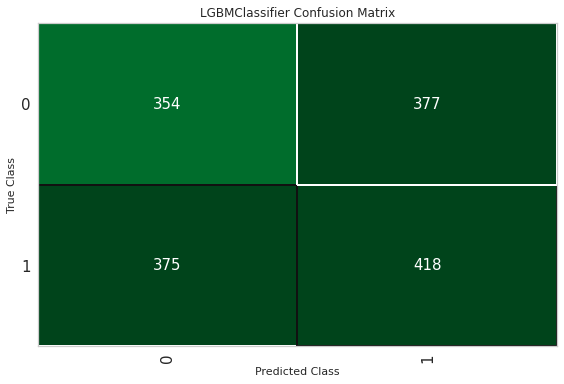

In [123]:
plot_model(MODEL, plot = 'confusion_matrix')

In [124]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5337,0.5646,0.6044,0.5392,0.5699,0.0643,0.0648
1,0.5084,0.5097,0.5110,0.5196,0.5152,0.0167,0.0167
2,0.4691,0.4596,0.5275,0.4824,0.5039,-0.0646,-0.0649
3,0.5268,0.5270,0.5691,0.5337,0.5508,0.0519,0.0520
4,0.4676,0.4637,0.4807,0.4780,0.4793,-0.0653,-0.0653
5,0.5014,0.5043,0.4862,0.5116,0.4986,0.0034,0.0034
6,0.5521,0.5474,0.5414,0.5632,0.5521,0.1046,0.1047
7,0.5296,0.5248,0.5801,0.5357,0.5570,0.0572,0.0574
8,0.5324,0.5384,0.5580,0.5401,0.5489,0.0638,0.0638
9,0.5408,0.5318,0.5359,0.5511,0.5434,0.0818,0.0819


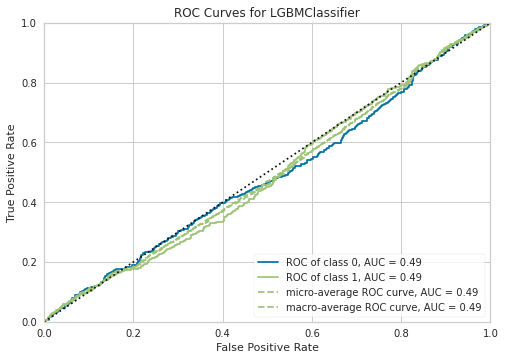

In [125]:
plot_model(TUNED_MODEL, plot = 'auc')

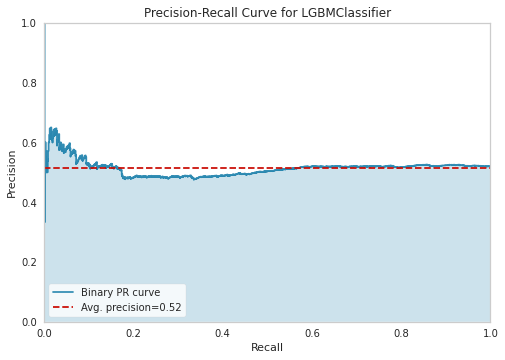

In [126]:
plot_model(TUNED_MODEL, plot = 'pr')

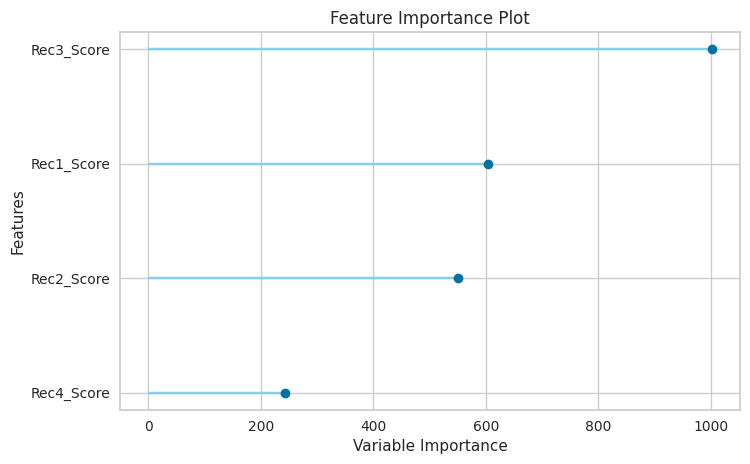

In [127]:
plot_model(TUNED_MODEL, plot='feature')

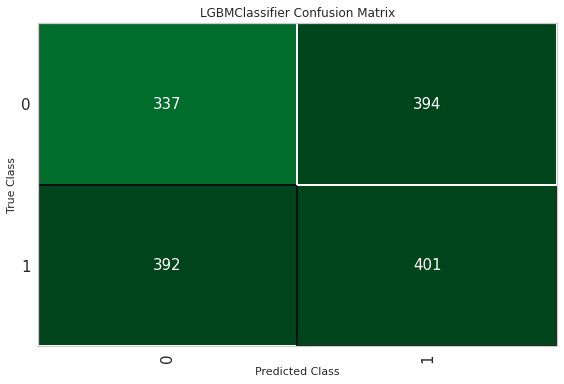

In [128]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [129]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.4843,0.4851,0.5057,0.5044,0.5050,-0.0333,-0.0333


In [130]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [131]:
print(FINAL_MODEL)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [132]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9140,0.9766,0.9357,0.9027,0.9189,0.8275,0.8281


In [133]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-61.76,-86.55,-75.93,16.74,1,0.6373
1,0,81.68,-73.63,82.94,-1.29,0,0.5821
2,1,3.88,86.33,-61.67,26.36,1,0.8755
3,1,-20.82,50.50,-83.59,12.96,1,0.8233
4,0,43.11,49.99,-17.58,66.50,0,0.7232


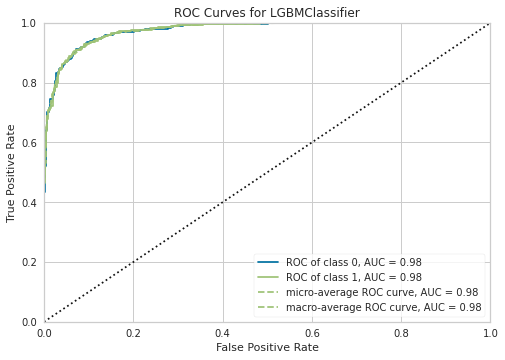

In [134]:
plot_model(FINAL_MODEL, plot = 'auc')

In [135]:
pkl_name = (today + "_" + model + "_" + pair)

In [136]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
             

In [137]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [138]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [139]:
data_unseen.shape

(2176, 5)

In [140]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-61.76,-86.55,-75.93,16.74,1,0.6373
1,0,81.68,-73.63,82.94,-1.29,0,0.5821
2,1,3.88,86.33,-61.67,26.36,1,0.8755
3,1,-20.82,50.50,-83.59,12.96,1,0.8233
4,0,43.11,49.99,-17.58,66.50,0,0.7232
5,1,-17.69,-90.50,-82.89,46.29,1,0.7852
6,1,-56.72,-60.13,-3.32,36.21,1,0.5750
7,1,-2.81,-28.19,0.22,3.70,1,0.6010
8,0,90.44,11.23,-21.49,94.96,0,0.7260
9,1,14.54,-59.22,70.64,12.50,1,0.7138


In [141]:
file = open(today + "_" + model + "_binary_classification_log_" + pair + ".txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()

### Final Test

In [142]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [144]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)
Test_Candle = list(random_samples.index.values)

In [145]:
#LR_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_LR_25Nov2021_EURUSD')
#ET_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_ET_25Nov2021_EURUSD')
#KNN_FINAL_MODEL = load_model('02-02-2022_03-42_AM_knn_EUR_USD')
#DT_FINAL_MODEL = load_model('FINAL_MODELS/USDCAD/10-01-2022_06-15_AM_dt_USDCAD')
#GBC_FINAL_MODEL = load_model('FINAL_MODELS/USDCAD/10-01-2022_07-12_AM_gbc_USDCAD')
LIGHTGBM_FINAL_MODEL = load_model('03-02-2022_06-56_PM_lightgbm_EURUSD')

Transformation Pipeline and Model Successfully Loaded


In [146]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
#                              'Rec1':[],
#                              'Rec1_P':[],
#                              'Rec2':[],
#                              'Rec2_P':[],
#                              'Rec3':[],
#                              'Rec3_P':[],
#                              'LR_Label':[],
#                              'LR_Score':[],
#                              'ET_Label':[],
#                              'ET_Score':[],
#                              'KNN_Label':[],
#                              'KNN_Score':[],
#                              'DT_Label':[],
#                              'DT_Score':[],
                              'LIGHTGBM_Label':[],
                              'LIGHTGBM_Score':[],
#                              'GBC_Label':[],
#                              'GBC_Score':[],                              
                             })

for candle_no in Test_Candle:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market= 1

    else:
        Current_Market = 0

    data = pd.read_csv(filename)
    data = data[[feature_9,
                 feature_10,
                 feature_11,
                 feature_12,
                 feature_13,
                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade = 'BUY'
            recs.append((r2_score(Y, y_pred)*100))
        else:
            Predicted_Trade = 'SELL'
            recs.append((r2_score(Y, y_pred)*100) * -1)
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
        
    data_unseen = pd.DataFrame ({
        'Rec1_Score': [recs[0]],
        'Rec2_Score': [recs[1]],
        'Rec3_Score': [recs[2]],
        'Rec4_Score': [recs[3]],
    })
    
#    lr_prediction = predict_model(LR_FINAL_MODEL, data=data_unseen)
#    LR_Label = lr_prediction['Label']
#    LR_Score = lr_prediction['Score']
    
#    et_prediction = predict_model(ET_FINAL_MODEL, data=data_unseen)
#    ET_Label = et_prediction['Label']
#    ET_Score = et_prediction['Score']
    
#    knn_prediction = predict_model(KNN_FINAL_MODEL, data=data_unseen)
#    KNN_Label = knn_prediction['Label']
#    KNN_Score = knn_prediction['Score']
    
#    dt_prediction = predict_model(DT_FINAL_MODEL, data=data_unseen)
#    DT_Label = dt_prediction['Label']
#    DT_Score = dt_prediction['Score']
    
    lightgbm_prediction = predict_model(LIGHTGBM_FINAL_MODEL, data=data_unseen)
    LIGHTGBM_Label = lightgbm_prediction['Label']
    LIGHTGBM_Score = lightgbm_prediction['Score']

#    gbc_prediction = predict_model(GBC_FINAL_MODEL, data=data_unseen)
#    GBC_Label = gbc_prediction['Label']
#    GBC_Score = gbc_prediction['Score']    
    
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
#              'Rec1': predicted_output[0][0],
#              'Rec1_P': predicted_output[0][1],
#              'Rec2': predicted_output[1][0],
#              'Rec2_P': predicted_output[1][1],
#              'Rec3': predicted_output[2][0],
#              'Rec3_P': predicted_output[2][1],
#              'LR_Label': LR_Label[0],
#              'LR_Score': LR_Score[0],
#              'ET_Label': ET_Label[0],
#              'ET_Score': ET_Score[0],
#              'KNN_Label': KNN_Label[0],
#              'KNN_Score': KNN_Score[0],
#              'DT_Label': DT_Label[0],
#              'DT_Score': DT_Score[0],
              'LIGHTGBM_Label': LIGHTGBM_Label[0],
              'LIGHTGBM_Score': LIGHTGBM_Score[0],
#              'GBC_Label': GBC_Label[0],
#              'GBC_Score': GBC_Score[0],              
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 03-02-2022_06-56_PM
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
CPU times: user 10h 16min 51s, sys: 8h 13min 34s, total: 18h 30min 26s
Wall time: 2h 52min 23s


In [147]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [148]:
result_output = result_output[result_output['Current_Market_Fit'] > 20]
result_output = result_output.reset_index()
del result_output['index']

In [149]:
result_output.shape

(7264, 5)

In [150]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [151]:
#result_output['LR_Prediction'] = result_output['Current_Market'] - result_output['LR_Label']
#result_output['ET_Prediction'] = result_output['Current_Market'] - result_output['ET_Label']
#result_output['KNN_Prediction'] = result_output['Current_Market'] - result_output['KNN_Label']
#result_output['DT_Prediction'] = result_output['Current_Market'] - result_output['DT_Label']
result_output['LIGHTGBM_Prediction'] = result_output['Current_Market'] - result_output['LIGHTGBM_Label']
#result_output['GBC_Prediction'] = result_output['Current_Market'] - result_output['GBC_Label']

In [152]:
LIGHTGBM_Result = pd.DataFrame(result_output['LIGHTGBM_Prediction'].value_counts())
LIGHTGBM_Result["Score"] = (LIGHTGBM_Result['LIGHTGBM_Prediction'] * 100 / len(result_output)).round(2)

In [153]:
result = pd.concat([
#    LR_Result,
#    ET_Result,
#    KNN_Result,
#    DT_Result,
#    GBC_Result,
    LIGHTGBM_Result,
], axis=1)
result

,LIGHTGBM_Prediction,Score
0.0,5393,74.24
-1.0,981,13.50
1.0,890,12.25
